In [9]:
# Install required library for Fuzzy C-Means
!pip install -q scikit-fuzzy

# Upload your kaggle.json file
from google.colab import files


# Set up Kaggle API and download the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jeetblahiri/bccd-dataset-with-mask
!unzip -q bccd-dataset-with-mask.zip

Dataset URL: https://www.kaggle.com/datasets/jeetblahiri/bccd-dataset-with-mask
License(s): unknown
100% 2.14G/2.15G [00:09<00:00, 316MB/s]
100% 2.15G/2.15G [00:09<00:00, 254MB/s]
replace BCCD Dataset with mask/test/mask/e02301ac-68f7-4daf-b2ba-254b917f1cca.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from glob import glob

# Set paths based on the extracted dataset structure
BASE_PATH = "BCCD Dataset with mask"

TEST_IMG_PATH = os.path.join(BASE_PATH, "test", "original")
TEST_MASK_PATH = os.path.join(BASE_PATH, "test", "mask")

# Get all files in both directories
raw_test_images = glob(os.path.join(TEST_IMG_PATH, "*"))
raw_test_masks  = glob(os.path.join(TEST_MASK_PATH, "*"))

# Create dictionaries to map the base filename (without extension) to its full path
img_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in raw_test_images}
mask_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in raw_test_masks}

# Find the filenames that exist in BOTH folders
common_names = sorted(list(set(img_dict.keys()).intersection(set(mask_dict.keys()))))

# Create our final, perfectly matched lists
test_images = [img_dict[name] for name in common_names]
test_masks  = [mask_dict[name] for name in common_names]

print(f"Raw Images: {len(raw_test_images)} | Raw Masks: {len(raw_test_masks)}")
print(f"✅ Successfully matched {len(test_images)} perfect image-mask pairs!")

Raw Images: 159 | Raw Masks: 159
✅ Successfully matched 159 perfect image-mask pairs!


In [12]:
def compute_dice_score(pred, gt):
    """Calculates boundary accuracy using Dice Coefficient."""
    intersection = np.sum(pred * gt)
    if (np.sum(pred) + np.sum(gt)) == 0:
        return 1.0
    return (2. * intersection) / (np.sum(pred) + np.sum(gt))

def preprocess(img_path, mask_path, size=(256, 256)):
    """Loads, resizes, and binarizes the image and mask."""
    # Read and resize image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)

    # Read, resize, and binarize mask
    mask = cv2.imread(mask_path, 0)
    # INTER_NEAREST prevents creating gray/fractional values during resize
    mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0).astype(np.uint8)

    return img, mask

def kmeans_segmentation(img, k=3):
    """Segments image using K-Means clustering (Hard Clustering)."""
    pixels = img.reshape((-1, 3)).astype(np.float32)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    return labels.reshape(img.shape[:2])

def fcm_segmentation(img, c=3):
    """Segments image using Fuzzy C-Means clustering (Soft Clustering)."""
    pixels = img.reshape((-1, 3)).T.astype(np.float64)
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixels, c=c, m=2, error=0.005, maxiter=300
    )
    labels = np.argmax(u, axis=0)
    return labels.reshape(img.shape[:2])

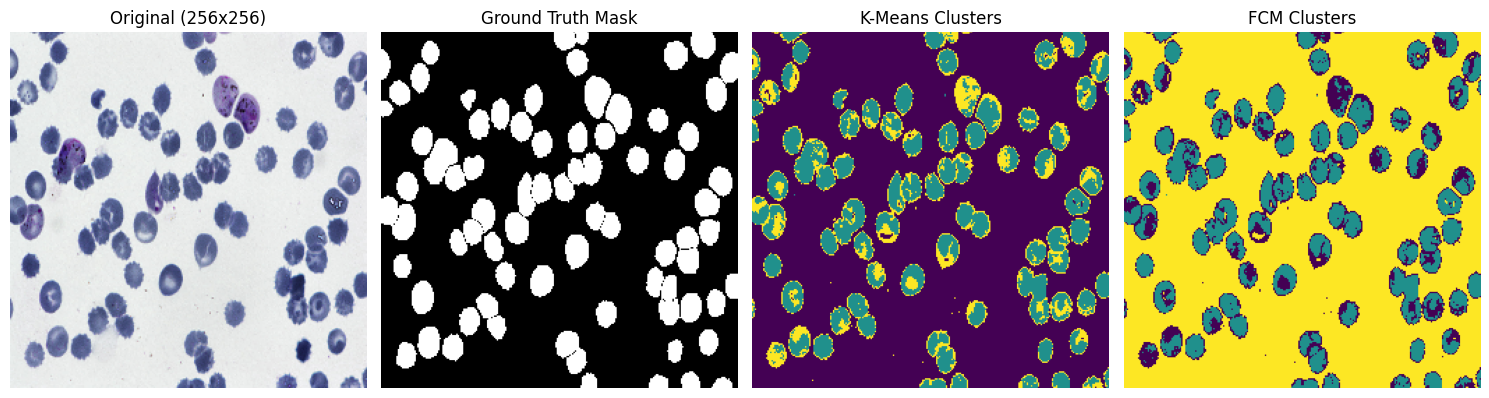

In [13]:
import random

# Pick a random image from the test set
idx = random.randint(0, len(test_images) - 1)
img, gt_mask = preprocess(test_images[idx], test_masks[idx])

# Run segmentation
k_seg = kmeans_segmentation(img)
f_seg = fcm_segmentation(img)

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1); plt.imshow(img); plt.title("Original (256x256)")
plt.axis('off')

plt.subplot(1, 4, 2); plt.imshow(gt_mask, cmap='gray'); plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 3); plt.imshow(k_seg, cmap='viridis'); plt.title("K-Means Clusters")
plt.axis('off')

plt.subplot(1, 4, 4); plt.imshow(f_seg, cmap='viridis'); plt.title("FCM Clusters")
plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
kmeans_scores = []
fcm_scores = []

print(f"Starting evaluation on {len(test_images)} test images...\n")

for i in range(len(test_images)):

    # Preprocess image and mask
    img, gt_mask = preprocess(test_images[i], test_masks[i])

    # Run algorithms
    k_seg = kmeans_segmentation(img)
    f_seg = fcm_segmentation(img)

    # Evaluate K-Means (Find which of the 3 clusters is the actual cell)
    best_acc_k = 0
    for cluster_id in np.unique(k_seg):
        candidate_mask = (k_seg == cluster_id).astype(np.uint8)
        score = compute_dice_score(candidate_mask, gt_mask)
        if score > best_acc_k:
            best_acc_k = score
    kmeans_scores.append(best_acc_k)

    # Evaluate FCM (Find which of the 3 clusters is the actual cell)
    best_acc_f = 0
    for cluster_id in np.unique(f_seg):
        candidate_mask = (f_seg == cluster_id).astype(np.uint8)
        score = compute_dice_score(candidate_mask, gt_mask)
        if score > best_acc_f:
            best_acc_f = score
    fcm_scores.append(best_acc_f)

    # Progress tracker
    if (i + 1) % 10 == 0:
        print(f"Processed {i + 1}/{len(test_images)} images...")

# Print Final Comparison
print("\n===== FINAL COMPARISON RESULT =====")
print(f"Average Boundary Accuracy (K-Means): {np.mean(kmeans_scores):.4f}")
print(f"Average Boundary Accuracy (FCM):     {np.mean(fcm_scores):.4f}")

Starting evaluation on 159 test images...

Processed 10/159 images...
Processed 20/159 images...
Processed 30/159 images...
Processed 40/159 images...
Processed 50/159 images...
Processed 60/159 images...
Processed 70/159 images...
Processed 80/159 images...
Processed 90/159 images...
Processed 100/159 images...
Processed 110/159 images...
Processed 120/159 images...
Processed 130/159 images...
Processed 140/159 images...
Processed 150/159 images...

===== FINAL COMPARISON RESULT =====
Average Boundary Accuracy (K-Means): 0.7601
Average Boundary Accuracy (FCM):     0.7436
